In [48]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.ensemble import RandomForestClassifier
tf.random.set_seed(2)

import pyhf

In [49]:
# Create output directory
OUT_DIR = "./MachineLearningRF/"
os.makedirs(OUT_DIR, exist_ok=True)

In [50]:
# Load the dataframe with MC data and their labels (signal = 1, background = 0)
dataframe = pd.read_csv('dataframe.csv')

In [51]:
# Create train weights such that the sum of train weights for signal and background is equal (ratio bkg/sig = 1:1)
dataframe['train_weight'] = 1.
dataframe.loc[dataframe.query('label==1').index,'train_weight'] = (dataframe.loc[dataframe.query('label==1').index,'scaleweight']) / dataframe.loc[dataframe.query('label==1').index,'scaleweight'].sum()
dataframe.loc[dataframe.query('label==0').index,'train_weight'] = dataframe.loc[dataframe.query('label==0').index,'scaleweight'] / dataframe.loc[dataframe.query('label==0').index,'scaleweight'].sum()

sum_w_sig = dataframe.query('label==0')['train_weight'].sum()
sum_w_bkg = dataframe.query('label==1')['train_weight'].sum()
print(f'Sum of weights for training Signal {sum_w_sig:.3} and Background {sum_w_bkg:.3}')

Sum of weights for training Signal 1.0 and Background 1.0


In [52]:
# Define the features and weights to be used for training
train_features = ['etmiss', 'mtw', 'leadleptPt', 'leadleptEta',
       'leadleptE', 'leadleptPhi', 'Q_leadlep', 'n_TopLRjets',
       'leadTopLRjet_pt', 'leadTopLRjet_eta', 'leadTopLRjet_phi',
       'leadTopLRjet_m', 'leadTopLRjet_Tau32', 'n_jets', 'leadjet_pt',
       'leadjet_eta', 'n_bjets', 'leadbjet_pt', 'leadbjet_eta', 'ttbarMLR']
weights = ["scaleweight", "train_weight"]

In [53]:
# Split the dataframe into train, validation and test samples, and scale the features
x_train, x_val, y_train, y_val, w_train_full, w_val_full = train_test_split(dataframe[train_features].values, dataframe['label'].values, dataframe[weights].values, train_size = 1/3, random_state = 64)
x_val, x_test, y_val, y_test, w_val_full, w_test_full = train_test_split(x_val, y_val, w_val_full, test_size=1/2, random_state = 64)

scaler = StandardScaler()
scaler.fit(x_train)

x_train = scaler.transform(x_train)
x_val = scaler.transform(x_val)
x_test = scaler.transform(x_test)


In [54]:
# Verify that the ratio of signal to background in the training, validation and test sets is equal to 1
print(f"Ratio of signal to background in training set: {w_train_full[:, 1][y_train==1].sum() / w_train_full[:, 1][y_train==0].sum():.2f}")
print(f"Ratio of signal to background in validation set: {w_val_full[:, 1][y_val==1].sum() / w_val_full[:, 1][y_val==0].sum():.2f}")
print(f"Ratio of signal to background in test set: {w_test_full[:, 1][y_test==1].sum() / w_test_full[:, 1][y_test==0].sum():.2f}")

Ratio of signal to background in training set: 1.03
Ratio of signal to background in validation set: 0.99
Ratio of signal to background in test set: 0.99


In [55]:
# Separate the weights into scaleweights to use in the fit, and train weights to use in the training
def weight_separation(w):
    scaleweights = w[:, 0]
    train = w[:, 1]
    return scaleweights, train

"""
w_<set>_scale are the scaleweights to be used in the fit
w_<set> are the train weights to be used in the training
"""
w_train_scale, w_train = weight_separation(w_train_full)
w_val_scale, w_val = weight_separation(w_val_full)
w_test_scale, w_test = weight_separation(w_test_full)

In [58]:
classifier = RandomForestClassifier(n_estimators = 200)
classifier.fit(x_train, y_train, sample_weight=w_train)
score = classifier.score(x_test, y_test, sample_weight=w_test)

pred_test = classifier.predict_proba(x_test)
pred_val = classifier.predict_proba(x_val)

sig_pred_test = pred_test[:, 1]
sig_pred_val = pred_val[:,1]

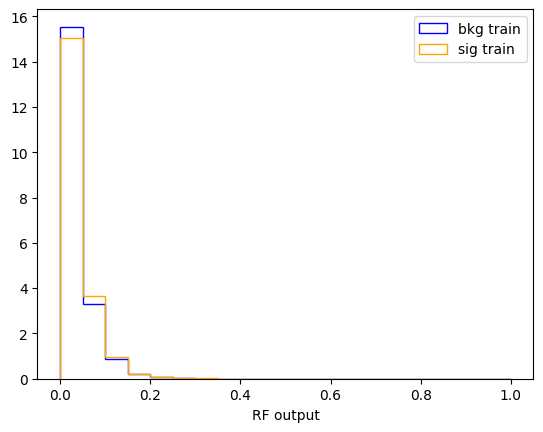

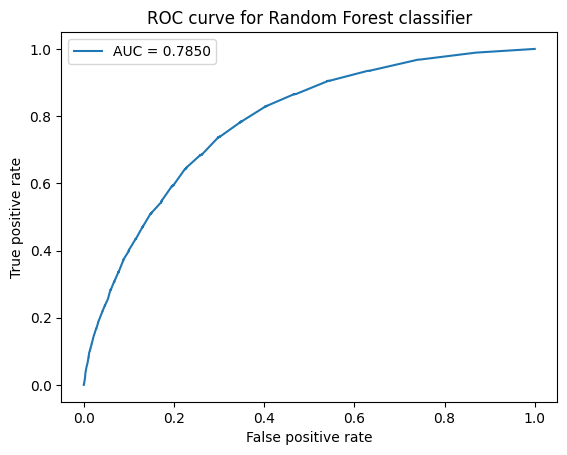

In [59]:
bins = plt.hist(sig_pred_test[np.where(y_test==0)], bins=20, density=True, histtype='step', color='blue', label='bkg train', range=(0, 1))
# plt.hist(sig_pred_val[np.where(y_val==0)], bins=bins[1], density=True, histtype='step', color='red', label='bkg validation', range=(0, 1))
plt.hist(sig_pred_test[np.where(y_train==1)], bins=bins[1], density=True, histtype='step', color='orange', label='sig train', range=(0, 1))
# plt.hist(sig_pred_val[np.where(y_val==1)], bins=bins[1], density=True, histtype='step', color='green', label='sig validation', range=(0, 1))
plt.xlabel('RF output')
plt.legend()
plt.show()

fpr, tpr, _ = roc_curve(y_test, sig_pred_test)
auc = roc_auc_score(y_test, sig_pred_test)
plt.plot(fpr, tpr, label=f'AUC = {auc:.4f}')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title("ROC curve for Random Forest classifier")
plt.legend()
plt.savefig(OUT_DIR + "ROC_curve.png")
plt.show()

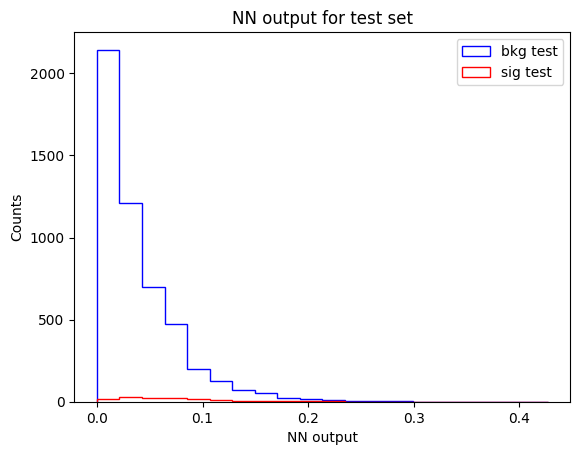

In [60]:
# Plot the histogram of the NN output for the test set
bin = plt.hist(sig_pred_test[y_test==0], bins=20, density=False, histtype='step', color='blue', label='bkg test', weights=w_test_scale[y_test==0])
plt.hist(sig_pred_test[y_test==1], bins=bin[1], density=False, histtype='step', color='red', label='sig test', weights=w_test_scale[y_test==1])

plt.xlabel('NN output')
plt.ylabel('Counts')
plt.title('NN output for test set')
plt.legend()
plt.savefig(OUT_DIR + "NN_test_output.png")
plt.show()

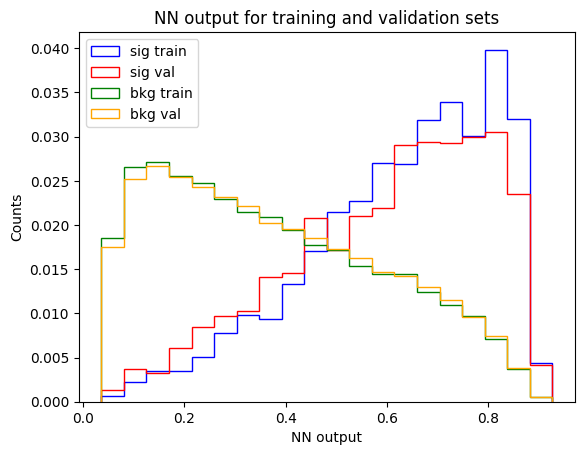

In [33]:
# Plot the histogram of the NN output for the training and validation sets
bins = plt.hist(y_train_pred[y_train==1], bins=20, density=False, histtype='step', color='blue', label='sig train', weights=w_train[y_train==1])
plt.hist(y_val_pred[y_val==1], bins=bins[1], density=False, histtype='step', color='red', label='sig val', weights=w_val[y_val==1])
bins = plt.hist(y_train_pred[y_train==0], bins=bins[1], density=False, histtype='step', color='green', label='bkg train', weights=w_train[y_train==0])
plt.hist(y_val_pred[y_val==0], bins=bins[1], density=False, histtype='step', color='orange', label='bkg val', weights=w_val[y_val==0])

plt.xlabel('NN output')
plt.ylabel('Counts')
plt.title('NN output for training and validation sets')
plt.legend()
plt.savefig(OUT_DIR + "NN_train_val_output.png")
plt.show()


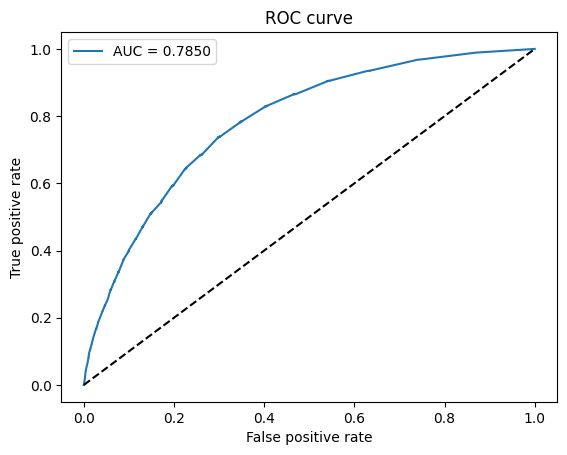

In [61]:
# ROC curve for the test set
fpr, tpr, thresholds = roc_curve(y_test, sig_pred_test)
auc = roc_auc_score(y_test, sig_pred_test)
plt.plot(fpr, tpr, label=f'AUC = {auc:.4f}')
plt.plot([0, 1], [0, 1], linestyle='--', color='black')
plt.title('ROC curve')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.legend()
plt.savefig(OUT_DIR + "ROC_curve.png")
plt.show()

In [63]:
# Create dataframe of the predictions and its respective scaleweights
def join_y_w(y, w):
    df = pd.DataFrame({'y_pred': y, 'scaleweights': w})
    return df

# df_train = join_y_w(y_train_pred[:, 0], w_train_scale[:])
# df_val = join_y_w(y_val_pred[:, 0], w_val_scale[:])
df_test = join_y_w(sig_pred_test, w_test_scale[:]*3) # Multiply by 3 to account for the 1/3 of the test set

In [64]:
# Import the measured data
data = pd.read_csv('Output_ZPrimeBoostedAnalysis/data.csv', delimiter= " ")
data

,etmiss,mtw,leadleptPt,leadleptEta,leadleptE,leadleptPhi,Q_leadlep,leadleptID,n_TopLRjets,leadTopLRjet_pt,...,n_bjets,leadbjet_pt,leadbjet_eta,ttbarMLR,largeRjet_pt_total,largeRjet_eta_total,largeRjet_phi_total,largeRjet_m_total,largeRjet_tau32_total,weight
0,140.8590,112.6010,173.3020,-0.719597,220.1410,-0.629445,1,11,1,303.808,...,2,74.2067,1.155760,0.000,303.808,0.716499,2.340630,105.440,0.701667,1
1,101.1240,12.9607,84.2450,0.521832,95.9780,1.694020,1,13,1,319.519,...,1,229.1180,-0.005455,0.000,319.519,-0.207688,-1.050650,124.417,0.658574,1
2,93.8502,145.9590,69.5917,-0.571767,81.2804,2.401100,1,11,1,379.502,...,1,354.8290,0.387903,0.000,379.502,0.429905,-0.032258,101.729,0.705147,1
3,79.1584,78.5076,39.4455,0.320825,41.4930,1.189650,-1,11,1,364.358,...,2,111.3740,-1.131620,0.000,673.232,-0.882717,2.047210,211.584,1.222030,1
4,49.9677,119.0770,78.1793,-1.261530,149.0890,-0.060379,1,11,1,381.640,...,4,327.3410,-0.637407,836.840,749.172,-1.939400,-0.584009,245.185,1.182330,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13983,51.2650,36.3069,32.4356,-1.826030,103.3120,2.875370,1,11,1,313.153,...,1,63.3124,-2.219060,0.000,313.153,-1.469270,-0.309966,149.170,0.428863,1
13984,177.2230,98.1917,226.8500,0.625051,272.6260,2.951550,-1,13,1,403.237,...,1,79.7143,0.725713,858.712,403.237,-0.551284,-0.521822,163.453,0.696539,1
13985,379.7260,76.7778,38.0448,0.559037,44.1463,-2.853520,1,13,1,618.111,...,2,120.5620,2.143520,0.000,883.045,1.610580,-3.028970,283.641,1.011700,1
13986,76.5990,32.0798,68.3700,-0.439462,75.0790,-0.758893,1,11,1,336.483,...,1,173.8460,1.078890,0.000,336.483,1.348570,1.986230,103.251,0.382302,1


In [66]:
# Apply the same scaling to the measured data and get the weights
x_data = scaler.transform(data[train_features].values)
w_data = data["weight"].values

# Compute the predictions for the measured data
y_data_pred = classifier.predict_proba(x_data)[:, 1]

# Create dataframe of the predictions and its respective weights
df_data = join_y_w(y_data_pred, w_data[:])

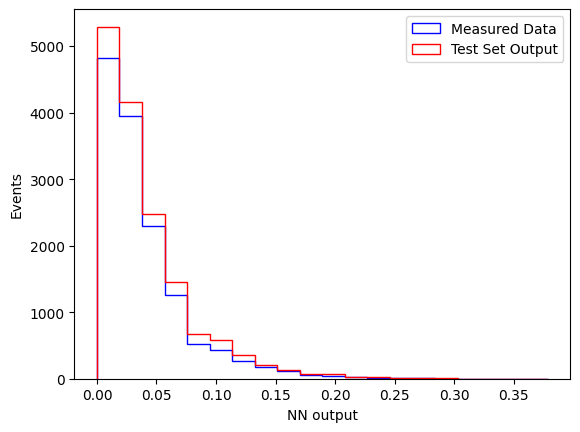

In [67]:
# Plot the histogram of the NN output for the measured data and the test set
bins = plt.hist(df_data['y_pred'], bins=20, histtype='step', color='blue', label='Measured Data', weights=df_data['scaleweights'])
plt.hist(df_test['y_pred'], bins=bins[1], histtype='step', color='red', label='Test Set Output', weights=df_test['scaleweights'])
plt.xlabel('NN output')
plt.ylabel('Events')
plt.legend()
plt.savefig(OUT_DIR + "NN_data_test_output.png")
plt.show()

In [68]:
# Create the distribution of the measured data and the test set signal and background NN output
N, bins = np.histogram(df_data['y_pred'], bins=20, weights=df_data['scaleweights'])

B = np.histogram(df_test['y_pred'][y_test==0], bins=bins, weights=df_test['scaleweights'][y_test==0])[0]
S = np.histogram(df_test['y_pred'][y_test==1], bins=bins, weights=df_test['scaleweights'][y_test==1])[0]


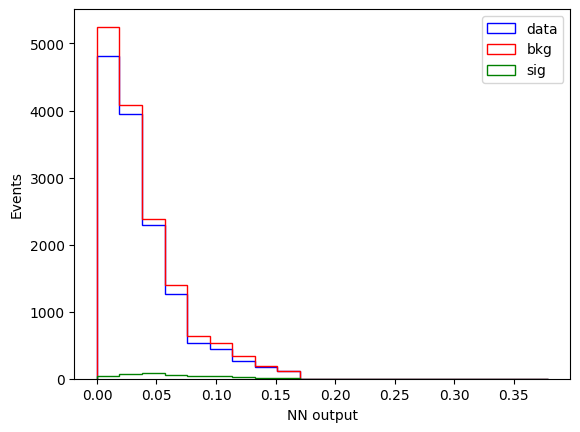

In [69]:
# Select the bins where there is less signal (the background is more pure) to use in the fit to discover the background normalization factor epsilon
N2 = N[:9]
B2 = B[:9]
S2 = S[:9]

#plot
plt.hist(bins[:9], bins, weights=N2, histtype='step', color='blue', label='data')
plt.hist(bins[:9], bins, weights=B2, histtype='step', color='red', label='bkg')
plt.hist(bins[:9], bins, weights=S2, histtype='step', color='green', label='sig')
plt.xlabel('NN output')
plt.ylabel('Events')
plt.legend()
plt.savefig(OUT_DIR + "NN_bkg_cut.png")
plt.show()

In [22]:
# Save the NN output and its respective type and weights to a csv file (measured data, test set, train set, validation set)
dataframe_to_save1 = pd.DataFrame({'Type': 'Observed', 'NN output': df_data['y_pred'], "weights": df_data['scaleweights']})
dataframe_to_save2 = pd.DataFrame({'Type': 'Test Bkg', 'NN output': df_test['y_pred'][y_test==0], "weights": (df_test['scaleweights'][y_test==0])/3})
dataframe_to_save3 = pd.DataFrame({'Type': 'Test Sig', 'NN output': df_test['y_pred'][y_test==1], "weights": (df_test['scaleweights'][y_test==1])/3})
dataframe_to_save4 = pd.DataFrame({'Type': 'Train Bkg', 'NN output': df_train['y_pred'][y_train==0], "weights": (df_test['scaleweights'][y_train==0])})
dataframe_to_save5 = pd.DataFrame({'Type': 'Train Sig', 'NN output': df_train['y_pred'][y_train==1], "weights": (df_test['scaleweights'][y_train==1])})
dataframe_to_save6 = pd.DataFrame({'Type': 'Val Bkg', 'NN output': df_val['y_pred'][y_val==0], "weights": (df_test['scaleweights'][y_val==0])})
dataframe_to_save7 = pd.DataFrame({'Type': 'Val Sig', 'NN output': df_val['y_pred'][y_val==1], "weights": (df_test['scaleweights'][y_val==1])})

dataframe_to_save = pd.concat([dataframe_to_save1, dataframe_to_save2, dataframe_to_save3, dataframe_to_save4, dataframe_to_save5, dataframe_to_save6, dataframe_to_save7])
dataframe_to_save.to_csv(OUT_DIR + "NN_output.csv", index=False)

In [23]:
dataframe_to_save

,Type,NN output,weights
0,Observed,0.314752,1.000000
1,Observed,0.187857,1.000000
2,Observed,0.228855,1.000000
3,Observed,0.134623,1.000000
4,Observed,0.364011,1.000000
...,...,...,...
83774,Val Sig,0.436028,0.193072
83786,Val Sig,0.577562,0.443364
83838,Val Sig,0.688606,0.011951
83924,Val Sig,0.537449,0.259007


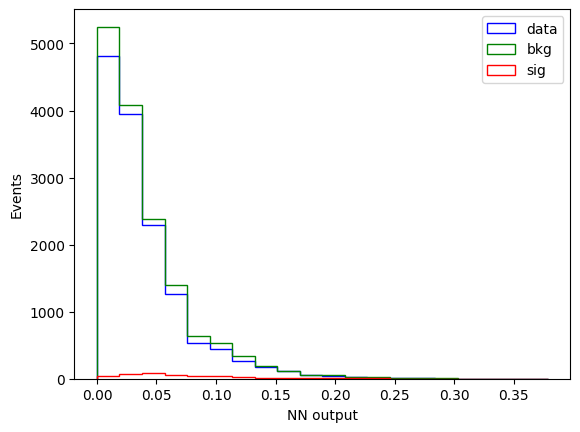

In [70]:
# Plot the distribution of the measured data, the signal and background
plt.hist(bins[:-1], bins, weights=N, histtype='step', color='blue', label='data')
plt.hist(bins[:-1], bins, weights=B, histtype='step', color='green', label='bkg')
plt.hist(bins[:-1], bins, weights=S, histtype='step', color='red', label='sig')

plt.xlabel('NN output')
plt.ylabel('Events')
plt.legend()
plt.savefig(OUT_DIR + "NN_NSB.png")
plt.show()

In [71]:
# Fit the model to the data to obtain the background normalization factor epsilon, using the bins with less signal

model_spec_discovery = {'channels': [{'name': 'singlechannel',
              'samples': [
              {'name': 'signal','data': S2.tolist(),
               'modifiers': []},
              {'name': 'bkg1','data': B2.tolist(),
               'modifiers': [{'data': None, 'name': 'epsilon', 'type': 'normfactor'}]},
              ]
              }],
              "observations": [{ "name": "singlechannel", "data": N2.tolist() }],
              "measurements": [{ "name": "Measurement", "config": {"poi": 'epsilon', "parameters": []}}],

              "version": "1.0.0",
}

workspace_discovery = pyhf.Workspace(model_spec_discovery)
model_discovery = workspace_discovery.model()

print("## Model")
print(f"  channels: {model_discovery.config.channels}")
print(f"     nbins: {model_discovery.config.channel_nbins}")
print(f"   samples: {model_discovery.config.samples}")
print(f" modifiers: {model_discovery.config.modifiers}")
print(f"parameters: {model_discovery.config.parameters}")
print(f"par. order: {model_discovery.config.par_order}")

print("\n## Model parameters")
print(f'   default: {model_discovery.config.suggested_init()}')
print(f'    bounds: {model_discovery.config.suggested_bounds()}')

data = N2.tolist() + model_discovery.config.auxdata

test_stat = "q0"
test_poi = 0.

best_pars = pyhf.infer.mle.fit(data=data, pdf=model_discovery)
print("\nBest fit parameters:")
print(f"  epsilon: {best_pars[0]:.2e}")

epsilon = best_pars[0]

## Model
  channels: ['singlechannel']
     nbins: {'singlechannel': 9}
   samples: ['bkg1', 'signal']
 modifiers: [('epsilon', 'normfactor')]
parameters: ['epsilon']
par. order: ['epsilon']

## Model parameters
   default: [1.0]
    bounds: [(0, 10)]

Best fit parameters:
  epsilon: 9.01e-01


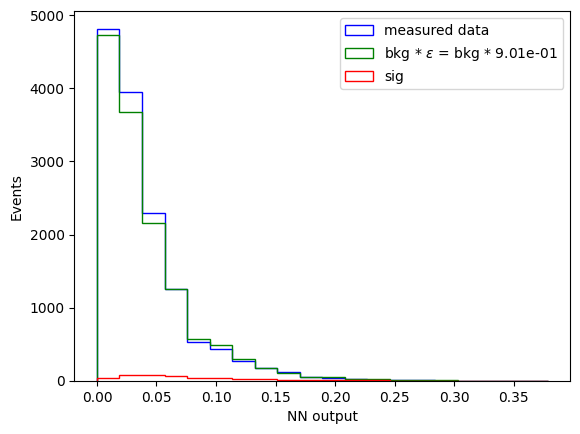

In [72]:
# Plot the distribution of the measured data, the signal and normalized background
B3 = epsilon * B

plt.hist(bins[:-1], bins, weights=N, histtype='step', color='blue', label='measured data')
plt.hist(bins[:-1], bins, weights=B3, histtype='step', color='green', label=r'bkg * $\epsilon$ = bkg * %.2e' % epsilon)
plt.hist(bins[:-1], bins, weights=S, histtype='step', color='red', label='sig')
plt.xlabel('NN output')
plt.ylabel('Events')
plt.legend()
plt.savefig(OUT_DIR + "NN_NSB_discovery.png")
plt.show()

In [74]:
# Exclusion Fit to obtain the upper limit on the signal strength
model_spec = {'channels': [{'name': 'singlechannel',
              'samples': [
              {'name': 'signal','data': S.tolist(),
               'modifiers': [{'data': None, 'name': 'mu', 'type': 'normfactor'}]},
              {'name': 'bkg1','data': B.tolist(),
               'modifiers': []},
              ]
              }],
              "observations": [{ "name": "singlechannel", "data": N.tolist() }],
              "measurements": [{ "name": "Measurement", "config": {"poi": 'mu', "parameters": []}}],

              "version": "1.0.0",
}

workspace = pyhf.Workspace(model_spec)
model = workspace.model()

print("## Model")
print(f"  channels: {model.config.channels}")
print(f"     nbins: {model.config.channel_nbins}")
print(f"   samples: {model.config.samples}")
print(f" modifiers: {model.config.modifiers}")
print(f"parameters: {model.config.parameters}")
print(f"par. order: {model.config.par_order}")

print("\n## Model parameters")
print(f'   default: {model.config.suggested_init()}')
print(f'    bounds: {model.config.suggested_bounds()}')

data = N.tolist() + model.config.auxdata

test_stat = "qtilde"
test_poi = 1.

# Vary mu values
poi_values = np.linspace(0.01, 5, 500)
obs_limit, exp_limits, (scan, results) = pyhf.infer.intervals.upper_limits.upper_limit(data, model, poi_values, level=0.05, return_results=True)
print(f"\nObserved μ upper limit (obs): {obs_limit:.3f}, Expected μ upper limit {exp_limits[2]:.3f}")

# CLs_obs, CLs_exp = pyhf.infer.hypotest(test_poi, data, model, test_stat=test_stat, return_expected=True)
# print(f"Observed CL_s: {CLs_obs}, Expected CL_s: {CLs_exp} ")

## Model
  channels: ['singlechannel']
     nbins: {'singlechannel': 20}
   samples: ['bkg1', 'signal']
 modifiers: [('mu', 'normfactor')]
parameters: ['mu']
par. order: ['mu']

## Model parameters
   default: [1.0]
    bounds: [(0, 10)]

Observed μ upper limit (obs): 0.071, Expected μ upper limit 0.415


In [75]:
# Exclusion Fit to obtain the upper limit on the signal strength
model_spec_norm = {'channels': [{'name': 'singlechannel',
              'samples': [
              {'name': 'signal','data': S.tolist(),
               'modifiers': [{'data': None, 'name': 'mu', 'type': 'normfactor'}]},
              {'name': 'bkg1','data': B3.tolist(),
               'modifiers': []},
              ]
              }],
              "observations": [{ "name": "singlechannel", "data": N.tolist() }],
              "measurements": [{ "name": "Measurement", "config": {"poi": 'mu', "parameters": []}}],

              "version": "1.0.0",
}

workspace = pyhf.Workspace(model_spec_norm)
model = workspace.model()

print("## Model")
print(f"  channels: {model.config.channels}")
print(f"     nbins: {model.config.channel_nbins}")
print(f"   samples: {model.config.samples}")
print(f" modifiers: {model.config.modifiers}")
print(f"parameters: {model.config.parameters}")
print(f"par. order: {model.config.par_order}")

print("\n## Model parameters")
print(f'   default: {model.config.suggested_init()}')
print(f'    bounds: {model.config.suggested_bounds()}')

data = N.tolist() + model.config.auxdata

test_stat = "qtilde"
test_poi = 1.

# Vary mu values
poi_values = np.linspace(0.01, 5, 500)
obs_limit_norm, exp_limits_norm, (scan, results) = pyhf.infer.intervals.upper_limits.upper_limit(data, model, poi_values, level=0.05, return_results=True)
print(f"\nObserved μ upper limit (obs): {obs_limit_norm:.3f}, Expected μ upper limit {exp_limits_norm[2]:.3f}")

## Model
  channels: ['singlechannel']
     nbins: {'singlechannel': 20}
   samples: ['bkg1', 'signal']
 modifiers: [('mu', 'normfactor')]
parameters: ['mu']
par. order: ['mu']

## Model parameters
   default: [1.0]
    bounds: [(0, 10)]

Observed μ upper limit (obs): 0.413, Expected μ upper limit 0.394


In [76]:
# save result to txt
with open(OUT_DIR + "results.txt", "w") as f:
    f.write(f"Value for epsilon (background normalization factor): {epsilon}\n")
    f.write(f"Observed μ upper limit (obs) with epsilon: {obs_limit_norm}\n")
    f.write(f"Expected μ upper limit (exp) with epsilon: {exp_limits_norm[2]}\n\n\n")
    f.write(f"Observed μ upper limit (obs): {obs_limit}\n")
    f.write(f"Expected μ upper limit (exp): {exp_limits[2]}\n")